In [6]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pip install albumentations==0.4.6

In [8]:
%cd /content/drive/MyDrive/IDSegmentation/RCar
!python train.py

/content/drive/MyDrive/IDSegmentation/RCar
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0% 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
100% 10/10 [00:20<00:00,  2.06s/it, loss=0.0915]
=========> saving checkpoint
EPOCH: 0 Got 49451139/393216000 ----> accuracy = 50.30
total loss in val dataset at epoch 0: 2.1977899074554443
100% 10/10 [00:11<00:00,  1.13s/it, loss=0.0739]
=========> saving checkpoint
EPOCH

In [ ]:
 %cd /content/drive/MyDrive/IDSegmentation/RCar
import torch

/content/drive/MyDrive/IDSegmentation/RCar


###Source download


In [ ]:
!pip install pixellib

In [ ]:
!pip install Pillow==9.0.0

In [ ]:
import torch
from torch.nn.modules import batchnorm
from torch.nn.modules.activation import ReLU 
import torchvision.transforms.functional as TF
import torch.nn as nn
from torchsummary import summary

class DoubleConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(DoubleConv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,1,1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels,out_channels,3,1,1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self,x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self,in_channels=3,out_channels=1,features=[64,128,256,512]):
        super(UNET,self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)

        #down part of unet
        for feature in features:
            self.downs.append(DoubleConv(in_channels,feature))
            in_channels = feature


        #up part of unet
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2,feature,kernel_size=2,stride=2))
            self.ups.append(DoubleConv(feature*2,feature))

        self.bottleneck = DoubleConv(features[-1],features[-1]*2)
        self.final_conv = nn.Conv2d(features[0],out_channels,kernel_size=1)
    
    def forward(self,x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        #reversed list
        skip_connections = skip_connections[::-1]
        for index in range(0,len(self.ups),2):
            x = self.ups[index](x)
            skip_connection = skip_connections[index//2]
            
            if x.shape != skip_connection.shape:
                x= TF.resize(x, size= skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection,x),dim=1)
            x = self.ups[index+1](concat_skip)
        
        return self.final_conv(x)

In [ ]:
import torch
from pixellib.torchbackend.instance import instanceSegmentation

(1, 960, 1280, 3)
(1, 960, 1280, 3)


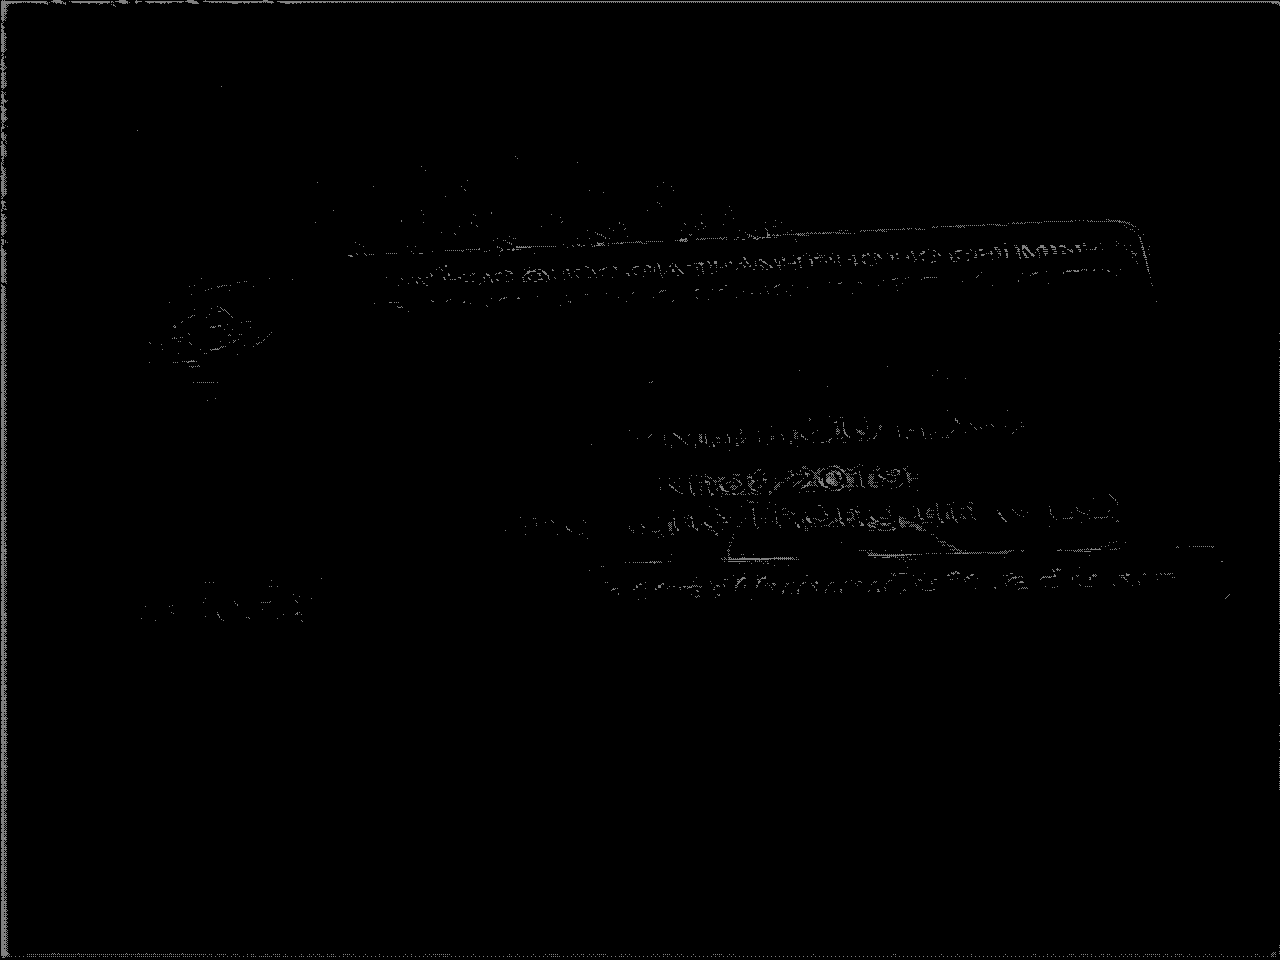

In [ ]:
import torch
from PIL import Image
import numpy as np
import cv2
import pandas as pd
from google.colab.patches import cv2_imshow
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNET(in_channels=3,out_channels=2,features=[16,32,64,128]).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/IDSegmentation/RCar/checkpoint_FCloss_g5.pth.tar")["state_dict"])
model.eval()
img = np.array(Image.open("/content/drive/MyDrive/IDSegmentation/dataset/1.jpg"),dtype=np.float32)
#img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
img = cv2.resize(img, (1280,960))
img = np.expand_dims(img,axis=0)
print(img.shape)
img = torch.Tensor(img).to(device)

img = img.permute(0,3,1,2)
def get_labels_info(info_path):
    info = pd.read_csv(info_path)
    class_names = np.array(info["name"])
    labels_values = np.array(info[["r","g","b"]])
    return class_names, labels_values

def one_hot_reverse(preds,info_path="class_dict.csv"):
    class_names, labels_values = get_labels_info(info_path)
    preds_np = np.array(preds.cpu(),dtype=np.float32)
    img = np.argmax(preds_np,axis=1)
    img_color = labels_values[img.astype(int)]
    return img_color

with torch.no_grad():
  preds = torch.sigmoid(model(img))
  preds = one_hot_reverse(preds,info_path="/content/drive/MyDrive/IDSegmentation/RCar/class_dict.csv")
  for i in range(len(preds)):
  #BGRpreds = cv2.cvtColor(preds[i],cv2.COLOR_RGB2BGR)
    #cv2.imwrite("test.png",preds)
    print(preds.shape)
    cv2_imshow(preds[0])



### Cv2 extraction and OCR

In [9]:
import os

In [10]:
os.listdir(r'/content/drive/MyDrive/IDSegmentation/dataset/data/')

['(27).jpg',
 '(31).jpg',
 '(34).jpg',
 '(26).jpg',
 '(33).jpg',
 '(30).jpg',
 '(9).jpg',
 '(10).jpg',
 '(7).jpg',
 '(21).jpg',
 '(5).jpg',
 '(23).jpg',
 '(20).jpg',
 '(8).jpg',
 '(22).jpg',
 '(25).jpg',
 '(32).jpg',
 '(24).jpg',
 '(36).jpg',
 '(40).jpg',
 '(35).jpg',
 '(3).jpg',
 '(2).jpg',
 '(1).jpg',
 '(6).jpg',
 '(17).jpg',
 '(4).jpg',
 '(15).jpg',
 '(14).jpg',
 '(18).jpg',
 '(12).jpg',
 '(16).jpg',
 '(13).jpg',
 '(11).jpg',
 '(19).jpg',
 '(29).jpg',
 '(28).jpg',
 '(39).jpg',
 '(37).jpg',
 '(38).jpg']

(1, 960, 1280, 3)


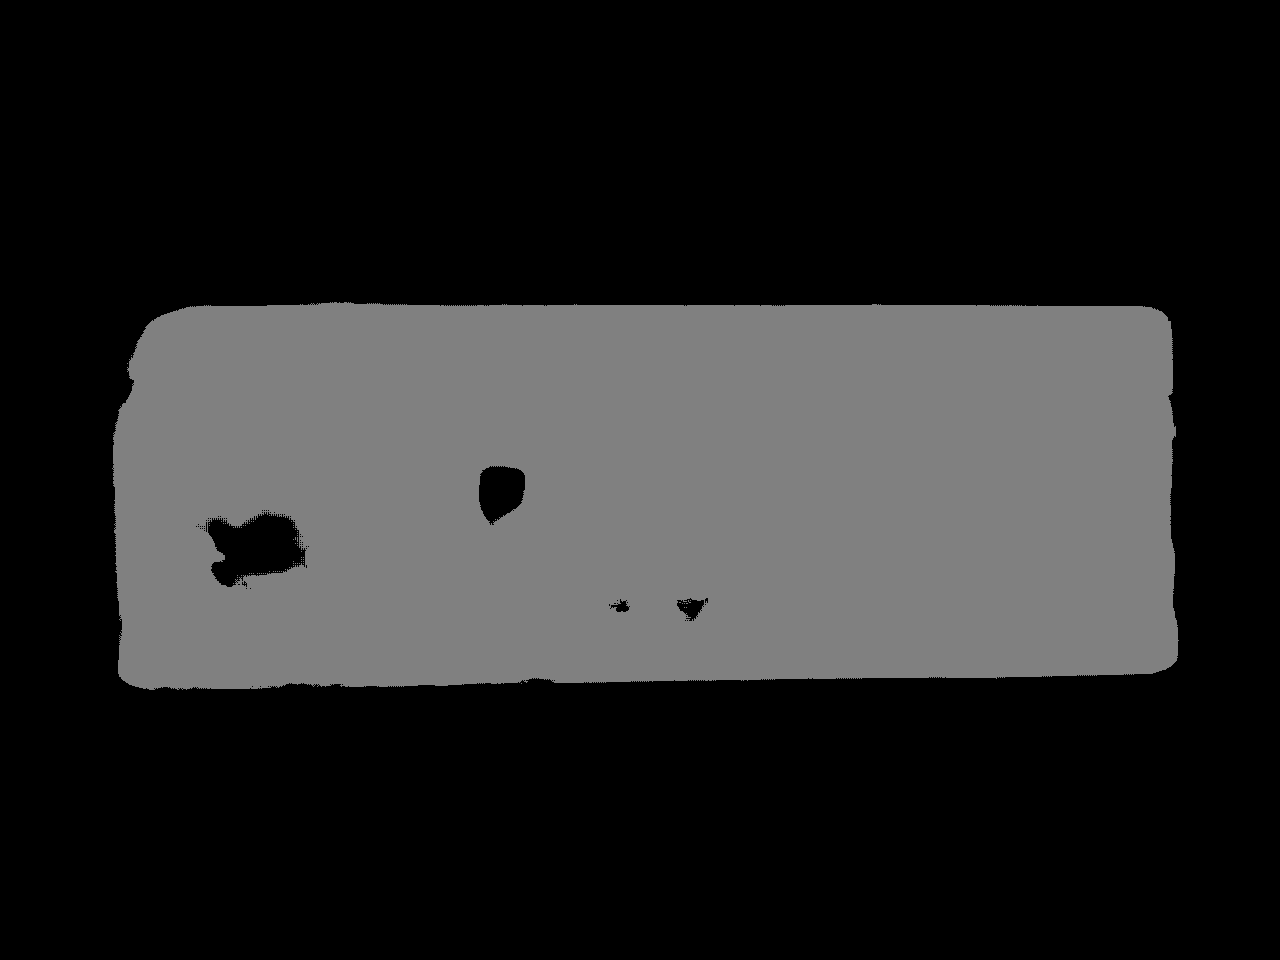

In [20]:
import torch
from torch.nn.modules import batchnorm
from torch.nn.modules.activation import ReLU 
import torchvision.transforms.functional as TF
import torch.nn as nn
from torchsummary import summary

class DoubleConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(DoubleConv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,1,1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels,out_channels,3,1,1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self,x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self,in_channels=3,out_channels=1,features=[64,128,256,512]):
        super(UNET,self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)

        #down part of unet
        for feature in features:
            self.downs.append(DoubleConv(in_channels,feature))
            in_channels = feature


        #up part of unet
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2,feature,kernel_size=2,stride=2))
            self.ups.append(DoubleConv(feature*2,feature))

        self.bottleneck = DoubleConv(features[-1],features[-1]*2)
        self.final_conv = nn.Conv2d(features[0],out_channels,kernel_size=1)
    
    def forward(self,x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        #reversed list
        skip_connections = skip_connections[::-1]
        for index in range(0,len(self.ups),2):
            x = self.ups[index](x)
            skip_connection = skip_connections[index//2]
            
            if x.shape != skip_connection.shape:
                x= TF.resize(x, size= skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection,x),dim=1)
            x = self.ups[index+1](concat_skip)
        
        return self.final_conv(x)
def get_labels_info(info_path):
    info = pd.read_csv(info_path)
    # info has format: [['obstacles' 59 193 246]...]
    # info = info.to_numpy()
    class_names = np.array(info["name"])
    labels_values = np.array(info[["r","g","b"]])
    return class_names, labels_values

def one_hot_reverse(preds,info_path="class_dict.csv"):
    class_names, labels_values = get_labels_info(info_path)
    preds_np = np.array(preds.cpu(),dtype=np.float32)
    img = np.argmax(preds_np,axis=1)
    img_color = labels_values[img.astype(int)]
    #img_color = torch.Tensor(img_color).permute(0,3,1,2)
    return img_color



(1, 960, 1280, 3)
(1, 960, 1280, 3)


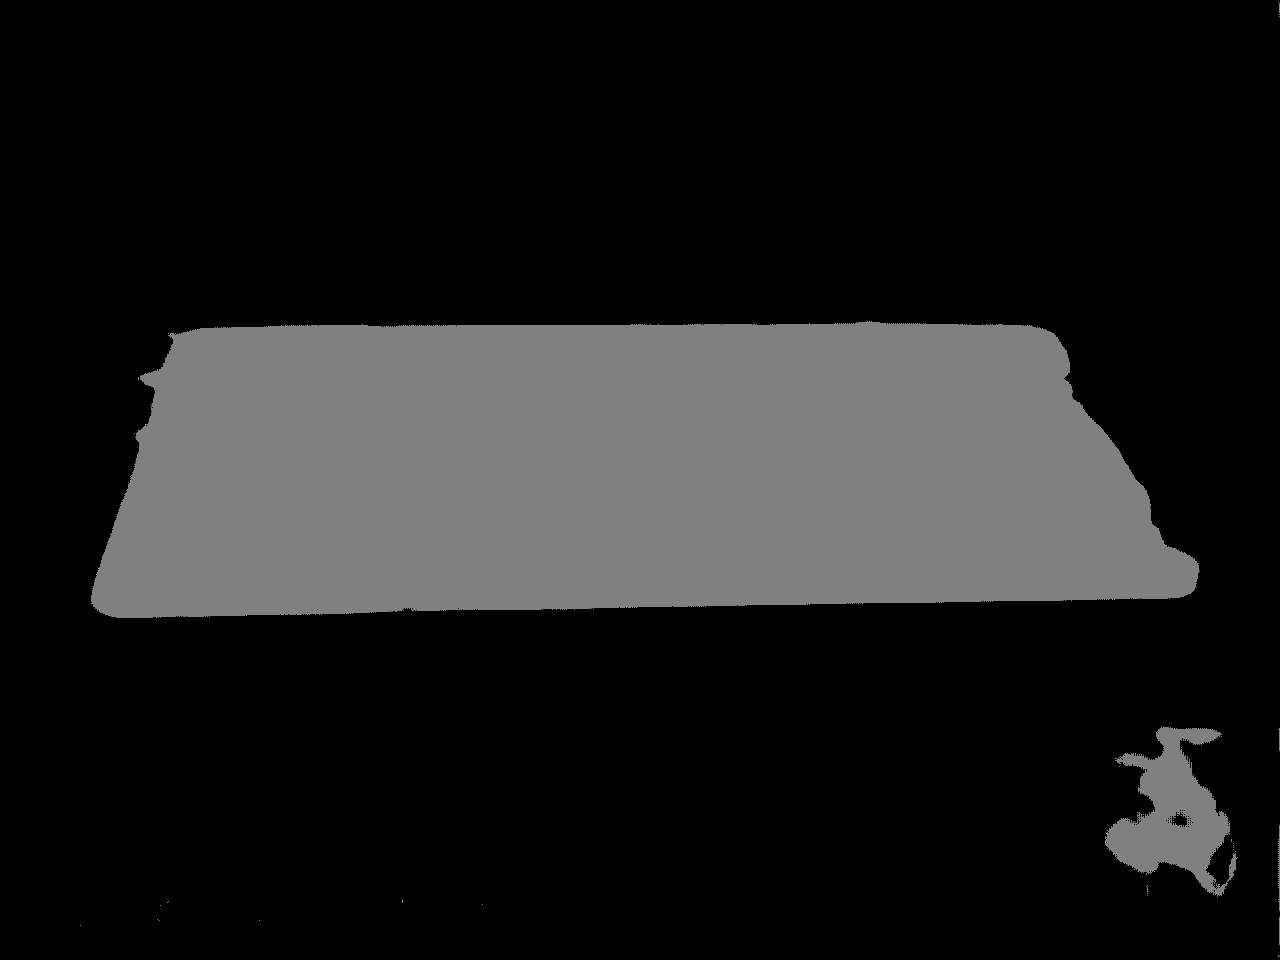

In [23]:
import torch
from PIL import Image
import numpy as np
import cv2
import pandas as pd
from google.colab.patches import cv2_imshow
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNET(in_channels=3,out_channels=2,features=[16,32,64,128]).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/IDSegmentation/RCar/checkpoint_FCloss_g5.pth.tar")["state_dict"])

img = np.array(Image.open(r"/content/drive/MyDrive/IDSegmentation/test1.jpg"),dtype=np.float32)
img = cv2.resize(img, (1280,960))
#img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
img = np.expand_dims(img,axis=0)
print(img.shape)
img = torch.Tensor(img).to(device)

img = img.permute(0,3,1,2)


with torch.no_grad():
  preds = torch.sigmoid(model(img))
  preds = one_hot_reverse(preds,info_path="/content/drive/MyDrive/IDSegmentation/RCar/class_dict.csv")
  for i in range(len(preds)):
  #BGRpreds = cv2.cvtColor(preds[i],cv2.COLOR_RGB2BGR)
    #cv2.imwrite("test.png",preds)
    print(preds.shape)
    cv2_imshow(preds[0])
